# 第8章 视觉处理基础
## 8.5 卷积神经网络分类实例
	这里以CIFAR-10作为数据集，使用Subclassing API构建网络，实现对图像的分类任务。
### 8.5.1 网络架构图
	整个网络架构由两层卷积层、在每个卷积层后跟一个池化层，最后为两个全连接层组成，详细网络结构，请参考图8-1。
### 8.5.2 使用Subclassing API构建网络
	创建一个名为MyCNN的类，该类继承tf.keras.Model，在类的构造函数（即__init__()函数）创建卷积层、池化层、全连接层等。然后在call函数中，构建网络。另外，为便于查看网络结构，增加一个名为model01的函数，如果没有这个函数，使用summary查看模型结构时，将不显示具体的shape信息。
### 8.5.3 卷积神经网络分类实例的主要步骤
	加载数据、预处理数据、定义模型、训练模型、测试模型，最后保存恢复模型等。数据加载及数据预处理等可参考第3章的实例或本书提供的代码数据部分。

## 1.导入模块

In [1]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

## 2.定义加载函数

In [2]:
def load_CIFAR_data(data_dir):
    """导入CIFAR数据集"""
 
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return (Xtrain,Ytrain),(Xtest,Ytest)

## 3.定义批量加载函数

In [3]:
def load_CIFAR_batch(filename):
    """ 批量加载数据集 """  
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='bytes')
        images= data_dict[b'data']
        labels = data_dict[b'labels']
                
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose (0,2,3,1)
     
        labels = np.array(labels)
        
        return images, labels

## 4.运行加载函数

In [4]:
data_dir = r'..\data\cifar-10-batches-py'
(x_train,y_train),(x_test,y_test) = load_CIFAR_data(data_dir)

loading  ..\data\cifar-10-batches-py\data_batch_1
loading  ..\data\cifar-10-batches-py\data_batch_2
loading  ..\data\cifar-10-batches-py\data_batch_3
loading  ..\data\cifar-10-batches-py\data_batch_4
loading  ..\data\cifar-10-batches-py\data_batch_5
finished loadding CIFAR-10 data


## 5.可视化加载数据

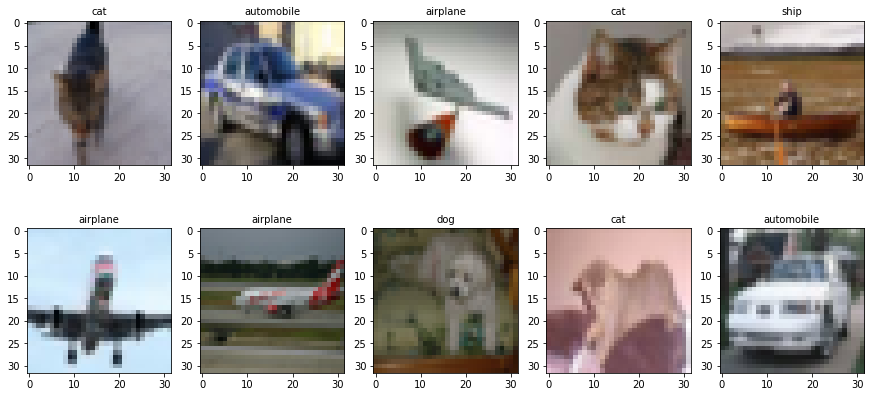

In [5]:
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
              5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}


def plot_images_labels(images, labels, num):
    total = len(images)
    fig = plt.gcf()
    fig.set_size_inches(15, math.ceil(num / 10) * 7)
    for i in range(0, num):
        choose_n = np.random.randint(0, total)
        
        ax = plt.subplot(math.ceil(num / 5), 5, 1 + i)
        ax.imshow(images[choose_n], cmap='binary')
        title = label_dict[labels[choose_n]]
        ax.set_title(title, fontsize=10)        
    plt.show()
    
plot_images_labels(x_train, y_train, 10)

## 6.对数据进行预处理

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

train_num = len(x_train)
num_classes = 10

learning_rate = 0.0002
batch_size = 64
training_steps = 20000
display_step = 1000

conv1_filters = 32
conv2_filters = 64
fc1_units = 256


random_normal = tf.initializers.RandomNormal()
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(5000).repeat(training_steps).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## 7.定义网络层

- --ini--函数：这个函数用于对所有独立的输入进行初始化。（独立的输入：特指和训练数据无关的输入）(这个函数仅被执行一次)
- build函数：这个函数用于当你知道输入Tensor的shape后，完成其余的初始化。（即需要知道数据的shape,但不需要知道数据的具体值）(注意：这个函数仅在Call被第一次调用时执行)
- build（self，input_shape（self，* args，** kwargs）函数：这个函数就是用来前向计算的函数了，此方法可用于使用add_weight()创建依赖于输入形状的权重。 __call __()将通过调用build()自动构建该层（如果尚未构建）。  

- get_config：如果要让自定义的Layer通过Functional API 组合成模型时可以被保存成h5模型，需要自定义get_config方法，如何设置
该函数呢？主要看传入__init__接口时有哪些配置参数，然后在get_config内一一的将它们转为字典键值并且返回使用。 此外，父类的config也是需要一并保存的。  
【说明】
- 一般我们只要继承自tf.keras.layers.Layer并且实现好 \__init__ 以及  call 两个接口就可以了
- build函数并非是必须的。如果你事先知道Tensor的shape，即数据是显式的，那么完全可以在—init—中执行build内初始化的内容，从而不需要定义build函数。当然build也有它的好处，就是当你事先不知道数据的shape时，build的作用就凸显出来了。
- 为什么不用外部调用就可以运行build()、call()等函数？在Layer() 类中有一个\__call__() 魔法方法（上述两个函数已经被tf集成在该函数下面），会被自动调用，因此不用外部调用，具体怎么个调用过程，请阅读源码。
- 运行build时，input_shape来自哪里？来自call函数中的第一个位置参数的shape，
可从Layer的__call__源码看出：   
def __call__(self, inputs, *args, **kwargs):  
  .....  
  input_shapes = nest.map_structure(lambda x: x.shape, inputs)  
  ......  
  
构建网络层的一般步骤为：
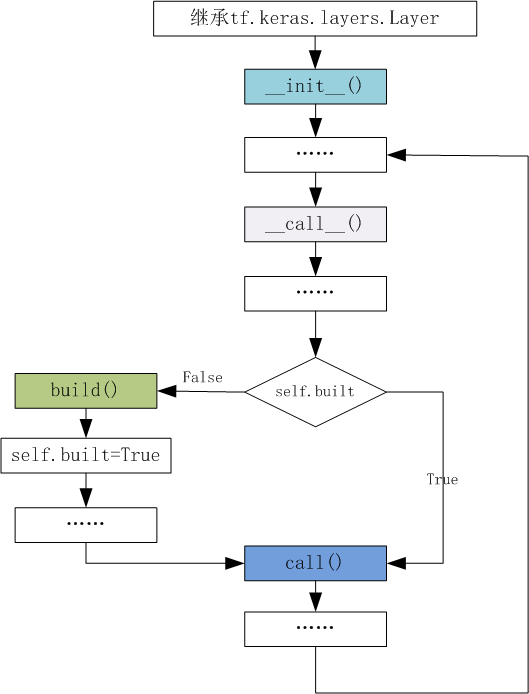

## 8.自定义模型结构

使用子类方法自定义模型结构的一般步骤：
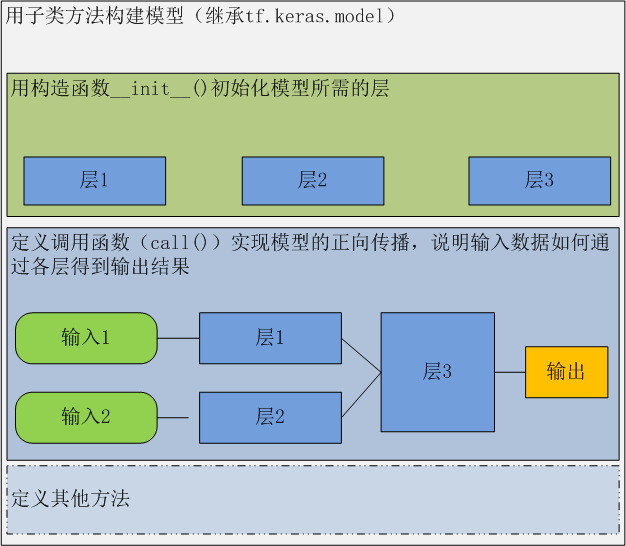

In [7]:
class MyCNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=16,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            input_shape=(32,32,3),
            padding="valid",         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=36,
            kernel_size=[3, 3],
            padding="valid",
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(6 * 6 * 36,))
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

  
    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 16]
        x = self.pool1(x)                       # [batch_size, 14, 14, 16]
        x = self.conv2(x)                       # [batch_size, 12, 12, 36]
        x = self.pool2(x)                       # [batch_size, 6, 6, 36]
        x = self.flatten(x)                     # [batch_size, 6 * 6 * 36]
        x = self.dense1(x)                      # [batch_size, 128]
        x = self.dense2(x)                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output
    #为使用summary时能显示tensor的shape
    def model01(self):
        x = tf.keras.Input(shape=(32, 32, 3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [8]:
model = MyCNN()

查看网络结构

In [9]:
model.model01().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 36)        5220      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 36)          0         
_________________________________________________________________
reshape (Reshape)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               166016

## 9.编译及训练模型

In [10]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
epochs = 10
batch_size = 64
learning_rate = 0.0002

In [12]:
train_history = model.fit(x_train, y_train,
                          validation_split=0.2,
                          epochs=epochs,
                          #steps_per_epoch=100,
                          batch_size=batch_size,
                          verbose=1)

Epoch 1/10
625/625 [==============================] - 8s 5ms/step - loss: 1.7970 - accuracy: 0.3473 - val_loss: 1.4127 - val_accuracy: 0.4941
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 1.2865 - accuracy: 0.5428 - val_loss: 1.1759 - val_accuracy: 0.5885
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 1.1343 - accuracy: 0.6041 - val_loss: 1.0974 - val_accuracy: 0.6169
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 1.0277 - accuracy: 0.6423 - val_loss: 1.0487 - val_accuracy: 0.6361
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.9513 - accuracy: 0.6651 - val_loss: 1.0289 - val_accuracy: 0.6402
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.8807 - accuracy: 0.6899 - val_loss: 0.9931 - val_accuracy: 0.6532
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.8044 - accuracy: 0.7197 - val_loss: 1.0105 - val_accuracy: 0.6523
Epoch 

可视化训练结果

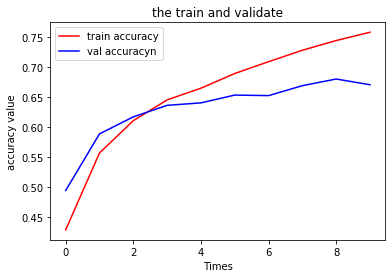

In [13]:
plt.title('the train and validate')
plt.xlabel('Times')
plt.ylabel('accuracy value')
plt.plot(train_history.history['accuracy'], color=(1, 0, 0), label='train accuracy')
plt.plot(train_history.history['val_accuracy'], color=(0, 0, 1), label='val accuracyn')
plt.legend(loc='best')
plt.show()


## 10.测试模型

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('test_loss:', test_loss,'\ntest_acc:', test_acc,'\nmetrics_names:', model.metrics_names)

313/313 - 1s - loss: 0.9710 - accuracy: 0.6696
test_loss: 0.9709934592247009 
test_acc: 0.6696000099182129 
metrics_names: ['loss', 'accuracy']


## 11.保存恢复模型

In [15]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


可以使用两种格式将整个模型保存到磁盘：TensorFlow SavedModel 格式和较早的 Keras H5 格式。 tensorflow官方推荐使用 SavedModel 格式。它是使用 model.save() 时的默认格式,这种保存方式适合Sequential, Functional Model, or Model subclass。

In [16]:
newmodel = keras.models.load_model('my_model')

In [17]:
newmodel.summary()

Model: "my_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  5220      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  166016    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290 

In [18]:
test_loss, test_acc = newmodel.evaluate(x_test, y_test, verbose=2)
print('test_loss:', test_loss,'\ntest_acc:', test_acc,'\nmetrics_names:', model.metrics_names)

313/313 - 1s - loss: 0.9710 - accuracy: 0.6696
test_loss: 0.9709934592247009 
test_acc: 0.6696000099182129 
metrics_names: ['loss', 'accuracy']
